### In 2020-02-03, fbprophet version 0.5, if you want use fbprophet in Windows system, remember 
- Keep the version of your 'holidays' package below 0.10.1
- Keep the version of your 'pandas' package below 1.0.0(maybe lower) if you want to use '.plot_components' function(or you will have error: AttributeError: 'DatetimeIndex' object has no attribute 'weekday_name'),however, you need at least 0.25.0 to install fbprophet 0.5, but all data you need can be found in the forecast,include 'trend','upper bound '...,you can draw it by yourself
- Install vs c++14 
- Install Pystan
- Install Plotly 
### Referance:
- https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html#modeling-holidays-and-special-events

- https://blog.csdn.net/qq_23860475/article/details/81354467

In [1]:
import numpy as np
import math
import pandas as pd
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import statsmodels as sm
from fbprophet import Prophet
plt.style.use('seaborn-talk')

Import data and replace vacancy data

In [5]:
df = pd.read_excel("AirQualityUCI.xlsx",parse_dates=[['Date', 'Time']])
df['Date_Time'] = pd.to_datetime(df.Date_Time , format = '%d/%m/%Y %H.%M.%S')
data = df.drop(['Date_Time'], axis=1)
data.index = df.Date_Time

#column want to predict
data['PT08.S2(NMHC)'][data['PT08.S2(NMHC)'] == -200] = None   
NewFrame = pd.DataFrame(data = data['PT08.S2(NMHC)'].values,
                        index = data.index,columns = {'PT08.S2(NMHC)'}) 

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### EDA

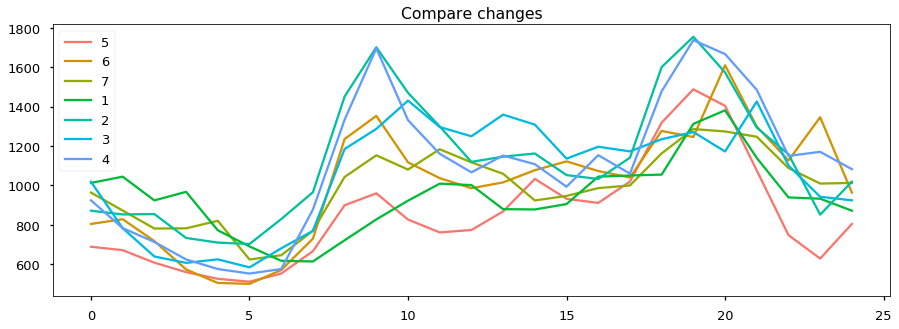

In [347]:
NewFrame_analyse = []
color_pal = ["#F8766D","#D39200","#93AA00","#00BA38","#00C19F","#00B9E3","#619CFF"]
ini = '2004-03-11 00:00:00'
plt.figure(figsize=(15,5))
days = 0


while(days<7):
    Single_week = (NewFrame.loc[ini:pd.to_datetime(ini)+ pd.to_timedelta('24:00:00')])['PT08.S2(NMHC)'].tolist()
    NewFrame_analyse.append(Single_week)
    ini = pd.to_datetime(ini)+ pd.to_timedelta('24:00:00')
    index = list(range(len(NewFrame_analyse[days])))
    plt.plot(index,NewFrame_analyse[days],
             c=color_pal[days],label = str((ini.dayofweek)+1))
    days+=1
plt.legend(loc='best')
plt.title('Compare changes')
plt.show()

- We can see at 19 and 9 o 'clock every day，data reach the max and at 5 a.m. it reach the bottom,so I try to construct "Holidays" DataFrame with these time

In [305]:
Holidays_max = []
Holidays_min = []
for Date in NewFrame.index:
    if(Date.hour == 9 or Date.hour == 19):
        Holidays_max.append(Date)
    elif(Date.hour == 5):
        Holidays_min.append(Date)

In [306]:
MAX = pd.DataFrame({
  'holiday': 'peaktime',
  'ds': pd.to_datetime(Holidays_max),
  'lower_window': 0,
  'upper_window': 0,
})
MIN = pd.DataFrame({
  'holiday': 'bottom_time',
  'ds': pd.to_datetime(Holidays_min),
  'lower_window': 0,
  'upper_window': 0,
})
holidays = pd.concat((MAX,MIN))

##### Result is here, compare to the model without holidays, it seems have a higher RMSE(166.43),so I won't use holidays in the final model, maybe parameters here should be modified or the number of holidays here is too much?

![jupyter](./images/With_holidays.jpg)

Split data,Cut-off point is "2005-01-16 15:00:00"

In [6]:
split = '2005-01-16 15:00:00'
PT08_Train = NewFrame.loc[NewFrame.index <= split].copy()
PT08_Test = NewFrame.loc[NewFrame.index > split].copy()

LOG

In [349]:
#PT08_Train = np.log(PT08_Train)
#PT08_Train.describe()

,PT08.S2(NMHC)
count,7206.000000
mean,6.829805
std,0.277785
min,5.982676
25%,6.635947
50%,6.836930
75%,7.033010
max,7.702556


It seems logistic model is not suitable here, because it's hard to know accurate bound of parameters of air quality.

In [7]:
model = Prophet(changepoint_prior_scale=0.05,growth='linear',
                seasonality_mode = 'multiplicative',seasonality_prior_scale = 15)
model.fit(PT08_Train.reset_index()\
            .rename(index = str,columns = {'Date_Time':'ds','PT08.S2(NMHC)':'y'}))

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
D:\Anaconda3\lib\site-packages\fbprophet\forecaster.py:400: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.



In [8]:
future = model.make_future_dataframe(periods=720,freq = 'H')

In [9]:
PT08_forecast = model.predict(future)

I tried to use a logarithmic transformation on the data，results be shown at the end

In [353]:
#PT08_forecast = pd.concat([PT08_forecast['ds'],np.exp(PT08_forecast.iloc[:,1:])],axis = 1)

Caculate RMSE, ignore the vacancy values(be filled with 0)

In [20]:
truth = PT08_Test.loc[:'2005-02-15 15:00:00'].fillna(0).values
predict = PT08_forecast[-720:].loc[:,'yhat'].values
sum = 0
count = 0
for x,y in zip(truth,predict):
    if(x == 0):
        count+=1
        break
    sum += (x[0]-y)**2
RMSE = (sum/(len(predict)-count))**0.5

Show the change of three constituent in paper(< Froecasting in scale >)

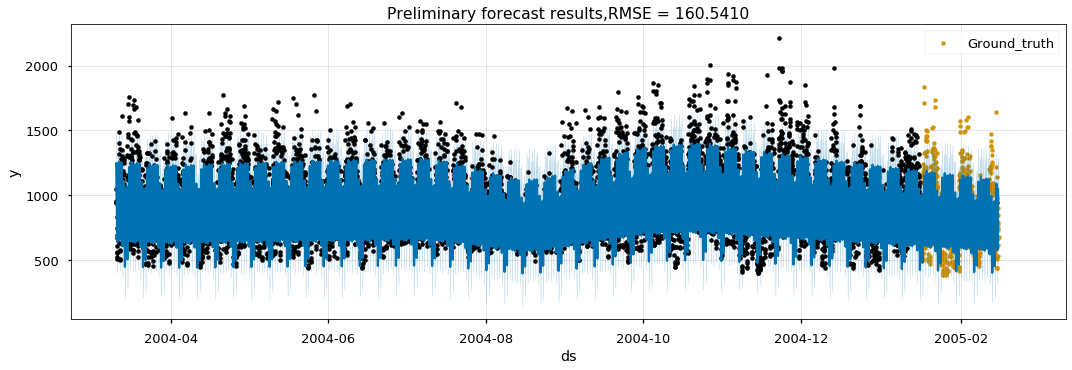

In [23]:
f,ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
plt.scatter(PT08_Test.loc[:'2005-02-15 15:00:00'].index,PT08_Test.loc[:'2005-02-15 15:00:00'],
            c='#D39200',label = 'Ground_truth',s = 15)
#PT08_forecast = np.exp(PT08_forecast)
model.plot(PT08_forecast,ax = ax)
plt.title('Preliminary forecast results,RMSE = %.4f'%RMSE)
plt.legend(loc = 'best')
#plt.savefig('With_holidays.jpg',dpi=400)

Results of data with log
![jupyter](./images/With_log.png)
And I have tried some parameters in Prophet() 

With linear growth and seasonality_mode = `multiplicative` 
- changepoint_prior_scale = 0.01 -->RMSE = 166.3978
- changepoint_prior_scale = 0.03 -->RMSE = 167.
- changepoint_prior_scale = 0.8 -->RMSE = 169.8228


- seasonality_prior_scale = 12 -->RMSE = 160.7896
- seasonality_prior_scale = 18 -->RMSE = 160.594
- seasonality_prior_scale = 20 -->RMSE = 160.818